# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Data

In [ ]:
username = 'mosobhy'
key = 'd27bc8af00ae9cc29626db5ef67c9ea9'

if '.kaggle' not in os.listdir('/root'):
  !mkdir ~/.kaggle

!touch ~/.kaggle/kaggle.json
!chmod 666 ~/.kaggle/kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as file:
  file.write('{"username":"%s","key":"%s"}' % (username, key))

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!cat ~/.kaggle/kaggle.json

{"username":"mosobhy","key":"d27bc8af00ae9cc29626db5ef67c9ea9"}

In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [00:27<00:00, 58.4MB/s]
100% 4.00G/4.00G [00:27<00:00, 156MB/s] 


In [ ]:
!unzip /content/state-farm-distracted-driver-detection.zip -d /content/dataset
!rm /content/state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/imgs/train/c7/img_56636.jpg  
  inflating: /content/dataset/imgs/train/c7/img_56661.jpg  
  inflating: /content/dataset/imgs/train/c7/img_56699.jpg  
  inflating: /content/dataset/imgs/train/c7/img_56717.jpg  
  inflating: /content/dataset/imgs/train/c7/img_56724.jpg  
  inflating: /content/dataset/imgs/train/c7/img_56768.jpg  
  inflating: /content/dataset/imgs/train/c7/img_56779.jpg  
  inflating: /content/dataset/imgs/train/c7/img_56849.jpg  
  inflating: /content/dataset/imgs/train/c7/img_56899.jpg  
  inflating: /content/dataset/imgs/train/c7/img_56938.jpg  
  inflating: /content/dataset/imgs/train/c7/img_5706.jpg  
  inflating: /content/dataset/imgs/train/c7/img_57076.jpg  
  inflating: /content/dataset/imgs/train/c7/img_57122.jpg  
  inflating: /content/dataset/imgs/train/c7/img_57137.jpg  
  inflating: /content/dataset/imgs/train/c7/img_5715.jpg  
  inflating: /content/dataset/imgs/train/c7/img_572

# Visualize Data

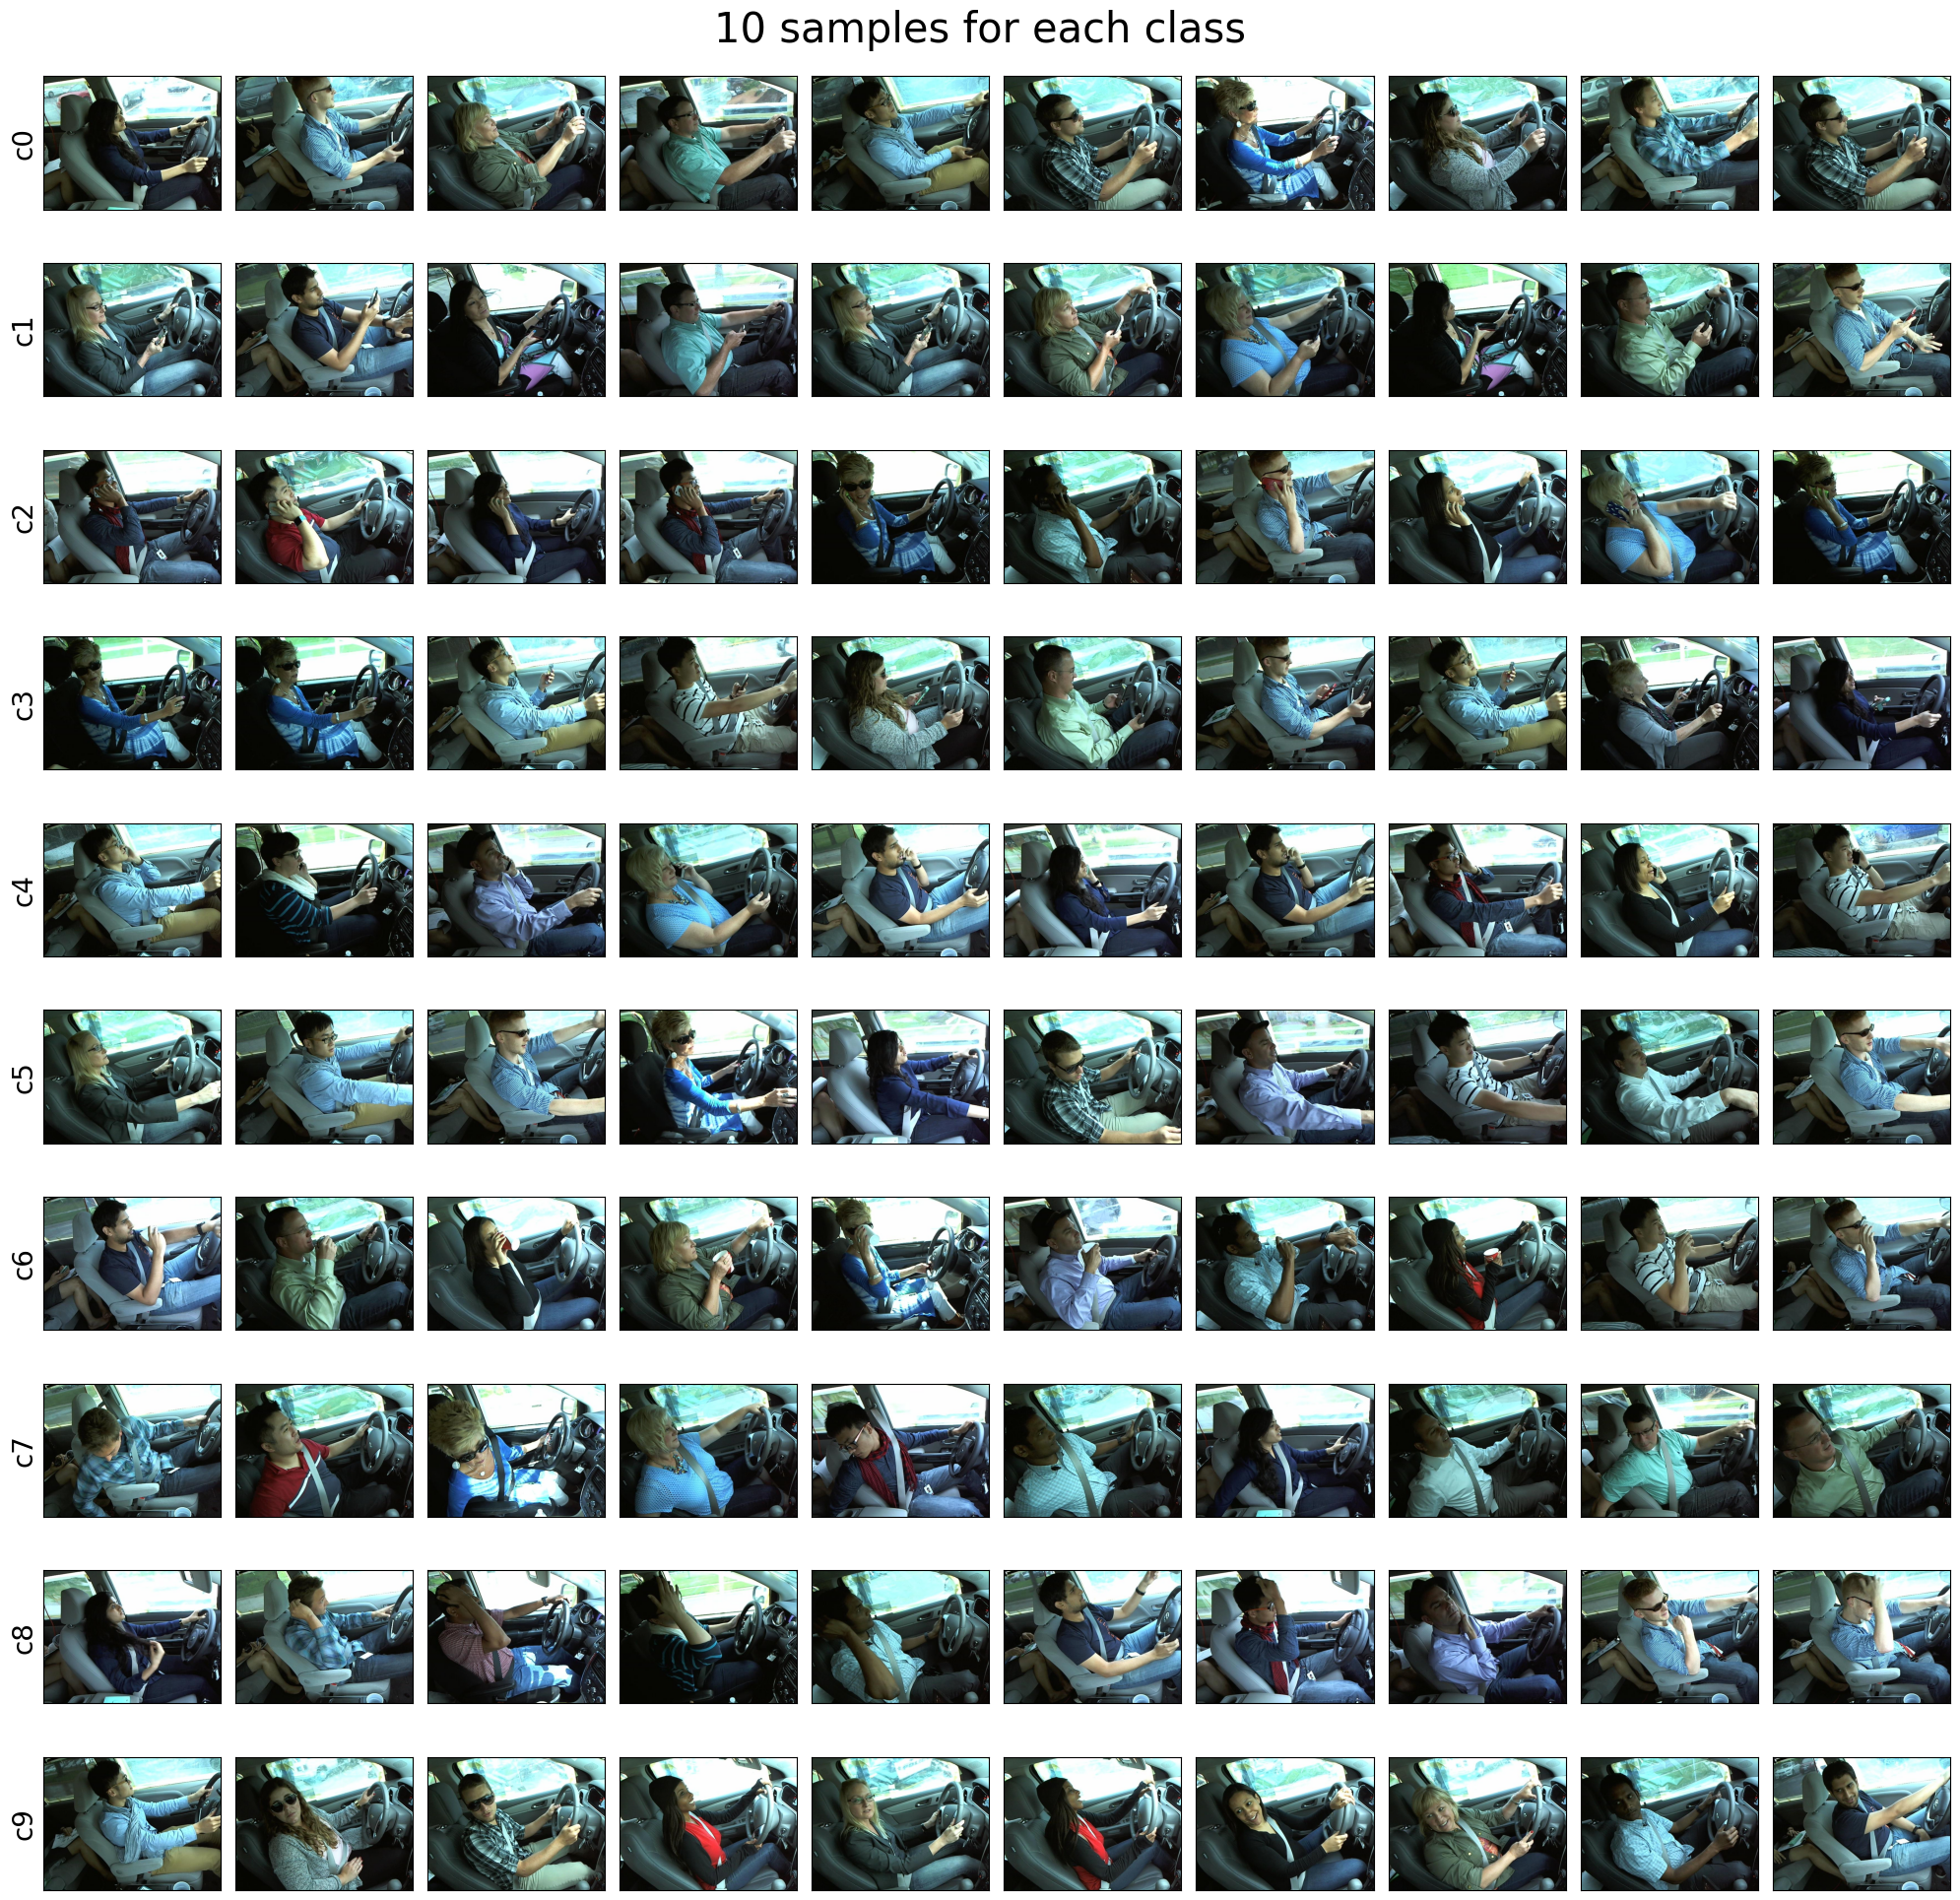

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

train_dir = 'dataset/imgs/train/'
labels = [f'c{i}' for i in range(10)]

for i, label in enumerate(labels):
  sample = os.listdir(train_dir+label)[:10]
  for j, img in enumerate(sample):
    img_path = train_dir+label+'/'+img
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i, j].imshow(img)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])

    if j == 0 :
      ax[i, j].set_ylabel(label, fontsize=20)

fig.suptitle('10 samples for each class', fontsize=30)
plt.tight_layout()

# Model

In [ ]:
evaluation_df = pd.DataFrame()
models_dict = {}

## ETL Pipeline for Baseline models

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/dataset/imgs/train'

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=.2
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='validation'
)

Found 20187 images belonging to 10 classes.
Found 2237 images belonging to 10 classes.


## Baseline Dense layers model

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Flatten(input_shape=(256, 256, 3)))
model.add(layers.Dense(512, activation='relu', name='layer_1'))
model.add(layers.Dense(256, activation='relu', name='layer_2'))
model.add(layers.Dense(128, activation='relu', name='layer_3'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 layer_1 (Dense)             (None, 512)               100663808 
                                                                 
 layer_2 (Dense)             (None, 256)               131328    
                                                                 
 layer_3 (Dense)             (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 100,829,322
Trainable params: 100,829,322
Non-trainable params: 0
_________________________________________________________________


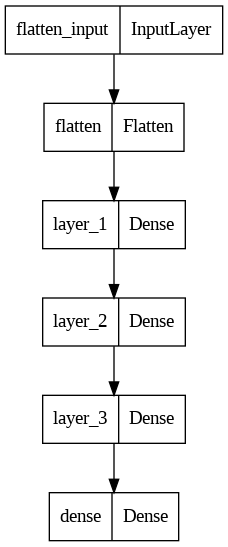

In [ ]:
from keras.utils import plot_model

plot_model(model)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
631/631 [==============================] - 151s 228ms/step - loss: 4.0710 - accuracy: 0.6375 - val_loss: 0.3700 - val_accuracy: 0.8820
Epoch 2/10
631/631 [==============================] - 147s 232ms/step - loss: 0.3204 - accuracy: 0.9010 - val_loss: 0.2009 - val_accuracy: 0.9397
Epoch 3/10
631/631 [==============================] - 145s 230ms/step - loss: 0.2276 - accuracy: 0.9287 - val_loss: 0.7622 - val_accuracy: 0.7886
Epoch 4/10
631/631 [==============================] - 144s 229ms/step - loss: 0.2122 - accuracy: 0.9325 - val_loss: 0.0862 - val_accuracy: 0.9785
Epoch 5/10
631/631 [==============================] - 145s 230ms/step - loss: 0.2414 - accuracy: 0.9268 - val_loss: 0.1345 - val_accuracy: 0.9584
Epoch 6/10
631/631 [==============================] - 144s 229ms/step - loss: 0.1331 - accuracy: 0.9587 - val_loss: 0.7385 - val_accuracy: 0.7984
Epoch 7/10
631/631 [==============================] - 145s 230ms/step - loss: 0.2096 - accuracy: 0.9335 - val_loss: 0.1071 -

##### Train VS Validation

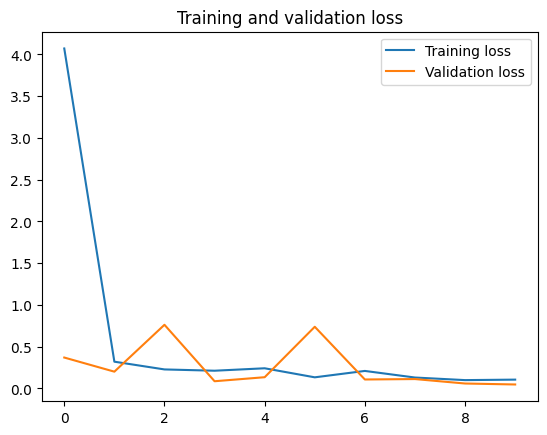

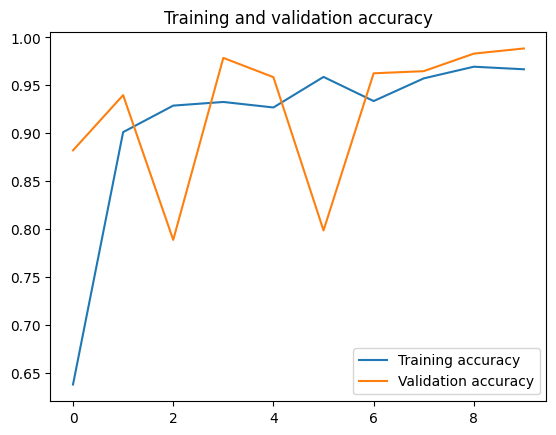

In [ ]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

##### Save model

In [ ]:
model.save('/content/drive/MyDrive/Distracted_Driver_Detection_baseline_dense.h5')

##### Save Performace

In [ ]:
model_name = 'Dense Baseline'
models_dict[model_name] = '/content/drive/MyDrive/Distracted_Driver_Detection_baseline_dense.h5'

train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

70/70 [==============================] - 14s 206ms/step - loss: 0.0474 - accuracy: 0.9884


## Baseline CNN model

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),  activation='relu',
                        input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),  activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))#, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)     

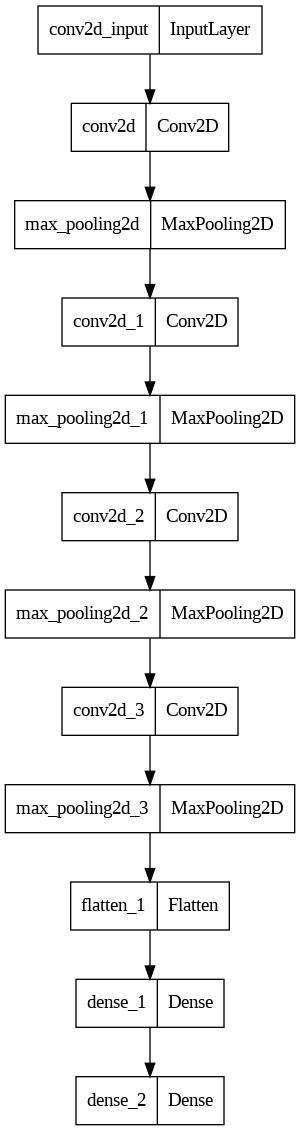

In [ ]:
from keras.utils import plot_model

plot_model(model)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
631/631 [==============================] - 168s 252ms/step - loss: 0.4843 - accuracy: 0.8409 - val_loss: 0.0847 - val_accuracy: 0.9754
Epoch 2/10
631/631 [==============================] - 153s 243ms/step - loss: 0.0522 - accuracy: 0.9847 - val_loss: 0.0571 - val_accuracy: 0.9835
Epoch 3/10
631/631 [==============================] - 165s 261ms/step - loss: 0.0220 - accuracy: 0.9936 - val_loss: 0.0314 - val_accuracy: 0.9920
Epoch 4/10
631/631 [==============================] - 161s 254ms/step - loss: 0.0202 - accuracy: 0.9942 - val_loss: 0.0358 - val_accuracy: 0.9897
Epoch 5/10
631/631 [==============================] - 159s 251ms/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0199 - val_accuracy: 0.9960
Epoch 6/10
631/631 [==============================] - 160s 254ms/step - loss: 0.0180 - accuracy: 0.9945 - val_loss: 0.0372 - val_accuracy: 0.9893
Epoch 7/10
631/631 [==============================] - 156s 247ms/step - loss: 0.0117 - accuracy: 0.9968 - val_loss: 0.0401 -

##### Train VS Validation

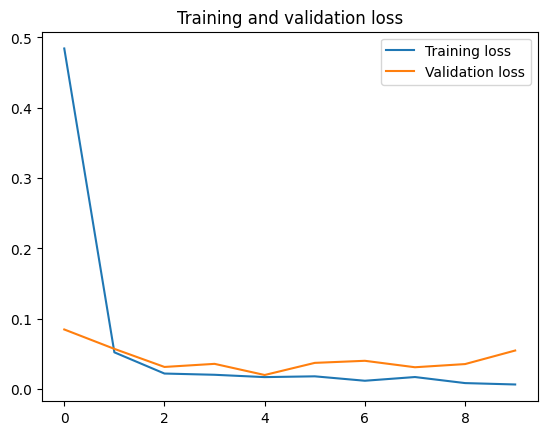

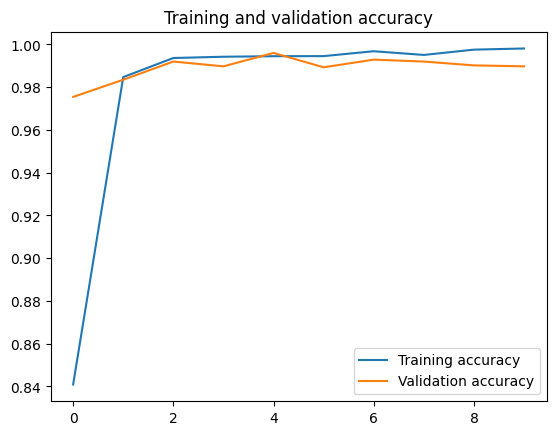

In [ ]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

##### Save model

In [ ]:
model.save('/content/drive/MyDrive/Distracted_Driver_Detection_baseline_cnn.h5')

##### Save Performace

In [ ]:
model_name = 'CNN Baseline'
models_dict[model_name] = '/content/drive/MyDrive/Distracted_Driver_Detection_baseline_cnn.h5'

train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

70/70 [==============================] - 15s 210ms/step - loss: 0.0547 - accuracy: 0.9897


## ETL Pipeline for data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/dataset/imgs/train'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.05,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05, 
                                   fill_mode='nearest',
                                   validation_split=.2)

# validation should not be augmented !
validation_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=.2)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


## CNN with Data augmentation

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),  activation='relu',
                        input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),  activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))#, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 128)     

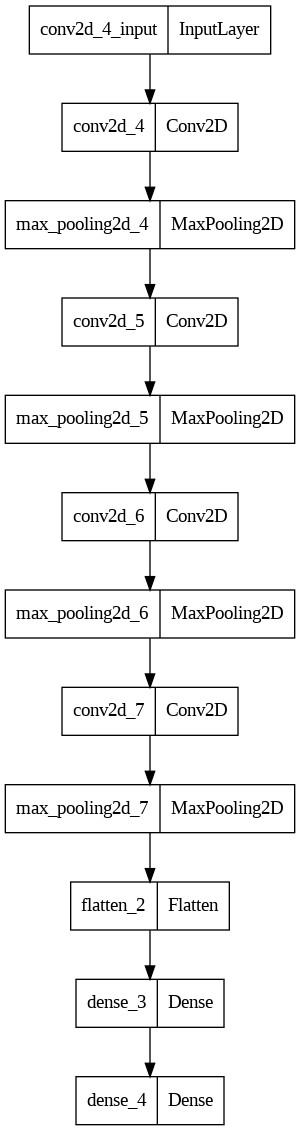

In [ ]:
from keras.utils import plot_model

plot_model(model)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
561/561 [==============================] - 364s 644ms/step - loss: 1.0190 - accuracy: 0.6466
Epoch 2/10
561/561 [==============================] - 363s 648ms/step - loss: 0.2222 - accuracy: 0.9292
Epoch 3/10
561/561 [==============================] - 360s 642ms/step - loss: 0.1213 - accuracy: 0.9633
Epoch 4/10
561/561 [==============================] - 360s 642ms/step - loss: 0.0866 - accuracy: 0.9739
Epoch 5/10
561/561 [==============================] - 359s 640ms/step - loss: 0.0710 - accuracy: 0.9769
Epoch 6/10
561/561 [==============================] - 360s 641ms/step - loss: 0.0586 - accuracy: 0.9816
Epoch 7/10
561/561 [==============================] - 361s 644ms/step - loss: 0.0492 - accuracy: 0.9846
Epoch 8/10
561/561 [==============================] - 361s 643ms/step - loss: 0.0459 - accuracy: 0.9843
Epoch 9/10
561/561 [==============================] - 367s 654ms/step - loss: 0.0428 - accuracy: 0.9858
Epoch 10/10
561/561 [==============================] - 364s 649m

##### Train VS Validation

In [ ]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

KeyError: ignored

##### Save model

In [ ]:
model.save('/content/drive/MyDrive/Distracted_Driver_Detection_cnn_data_augmentation.h5')

##### Save Performace

In [ ]:
model_name = 'CNN & Data Augmentation'
models_dict[model_name] = '/content/drive/MyDrive/Distracted_Driver_Detection_cnn_data_augmentation.h5'

train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

## ETL Pipeline for Transfer Learning

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

train_dir = '/content/dataset/imgs/train'

train_datagen = ImageDataGenerator(
                                   preprocessing_function=preprocess_input,
                                   zoom_range=0.05,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05, 
                                   fill_mode='nearest',
                                   validation_split=.2)

# validation should not be augmented !
validation_datagen = ImageDataGenerator(
                                        preprocessing_function=preprocess_input,
                                        validation_split=.2)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


## Transfer Learning

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top = False,
                  input_shape=(256, 256, 3))

conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               8388864   
                                                                 
 dense_8 (Dense)             (None, 10)                2570      
                                                                 
Total params: 23,106,122
Trainable params: 8,391,434
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      )

##### Train VS Validation

In [ ]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

##### Save model

In [ ]:
model.save('/content/drive/MyDrive/Distracted_Driver_Detection_transfer_learning.h5')

##### Save Performace

In [ ]:
model_name = 'Transfer-Learning'
models_dict[model_name] = '/content/drive/MyDrive/Distracted_Driver_Detection_transfer_learning.h5'

train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

## Fine-tuning

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top = False,
                  input_shape=(256, 256, 3))

conv_base.trainable = False

In [ ]:
conv_base.summary()

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      epochs=5,
      validation_data=validation_generator)

In [ ]:
conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
      break
    else:
        layer.trainable = False

In [ ]:
model.summary()

In [ ]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

##### Train VS Validation

In [ ]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

##### Save model

In [ ]:
model.save('/content/drive/MyDrive/Distracted_Driver_Detection_fine_tuning.h5')

##### Save Performace

In [ ]:
model_name = 'Fine-Tuning'
models_dict[model_name] = '/content/drive/MyDrive/Distracted_Driver_Detection_fine_tuning.h5'

train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

# Evaluation

In [ ]:
evaluation_df

In [ ]:
from keras.models import load_model
# Get best model according to validation score
best_model = evaluation_df[evaluation_df['Validation'] == evaluation_df['Validation'].max()]['Model'].values[0]
model = load_model(models_dict[best_model])

In [ ]:
model.summary()

# Submission File Generation

### Utility Functions

In [ ]:
def preprocess(images, rescale=1./255):
  """
  Takes numpy array.
    Args:
      rescale: rescaling factor. Defaults to None. If None or 0, no rescaling
        is applied, otherwise we multiply the data by the value provided
        (after applying all other transformations).

  Returns:
      A numpy array
  """

  # apply the pre-processing that utilized during training.
  if rescale and rescale != 0 :
    images = images*rescale
  
  return images 

In [ ]:
# def test_flow_from_directory(directory, batch_size=32, target_size=(256, 256), preprocess_input=None, shuffle=False):
#   """
#   Takes the path to a directory & generates batches.
#     Args:
#       directory: string, path to the target directory. 
#       batch_size: Size of the batches of data (default: 32).
#       target_size: Tuple of integers `(height, width)`, The dimensions to which all images found will be resized,
#         defaults to `None`.
#       rescale: rescaling factor. Defaults to None. If None or 0, no rescaling
#         is applied, otherwise we multiply the data by the value provided
#         (after applying all other transformations).
#       shuffle: Whether to shuffle the data (default: True).
#       preprocess_input: the pre-processing function that utilized during training.

#   Returns:
#       A numpy array containing a batch of images with shape
#       `(batch_size, *target_size, channels)`
#   """


#   file_names = os.listdir(directory)
#   if shuffle:
#     random.shuffle(file_names)

#   for i in range(len(file_names)+1//batch_size):

#     # get batch 
#     start = i * batch_size
#     end = (i+1) * batch_size
#     batch_file_names = file_names[start:end]
#     batch_file_names_path = list(map(lambda name: directory+'/'+name, batch_file_names))

#     # read image in BGR format
#     images = np.array(list(map(lambda file: cv2.imread(file), batch_file_names_path)))
    
#     # convert image to RGB format
#     images = np.array(list(map(lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2RGB), images)))

#     # pre-processing 
#     if preprocess_input:
#       images = np.array(list(map(lambda x: cv2.resize(x, target_size), images)))
#       images = preprocess_input(images)
    
#     yield batch_file_names, images

### Inference using manual test generator (test_flow_from_directory)

In [ ]:
# from keras.applications.imagenet_utils import preprocess_input

# # Get the pre-processing function that utilized during training.
# if best_model in('Fine-Tuning', 'Transfer-Learning'):
#     preprocess_function = preprocess_input
# else:
#     preprocess_function = preprocess

In [ ]:
# submission_df = pd.DataFrame()

# test_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/test'

# for batch_file_names, images in (test_flow_from_directory(test_dir,
#                                                           preprocess_input=preprocess_function)):
#   # model predictions
#   predictions = model.predict(images, verbose=0)
  
#   # concat image file name with its prediction
#   arr = np.array([[batch_file_names[i]] + predictions.tolist()[i] for i in range(len(predictions))])
  
#   # appned image file name with its prediction as a record in dataframe
#   submission_df = pd.concat((submission_df, pd.DataFrame(arr)))

get columns names from sample_submission csv and assign it to our dataframe

In [ ]:
# sample_submission_df = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv')

# submission_df.columns = sample_submission_df.columns
# submission_df.columns

In [ ]:
# submission_df.head()

In [ ]:
# submission_df.to_csv('/content/submission.csv', index=False)

### Inference using built-in test_generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

# Get the pre-processing function that utilized during training.
if best_model in('Fine-Tuning', 'Transfer-Learning'):
    preprocess_function = preprocess_input
else:
    preprocess_function = preprocess

test_dir = '/content/dataset/imgs/'

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_function)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(256, 256),
    batch_size = 32,
    classes=['test'],
    class_mode=None,
    shuffle=False
)

In [ ]:
file_names = sorted(os.listdir(test_dir+'test'))
len(file_names)

In [ ]:
predictions = model.predict(test_generator, verbose=0)
predictions.shape

In [ ]:
submission_df = pd.DataFrame()

# concat image file name with its prediction
arr = np.array([[file_names[i]] + predictions.tolist()[i] for i in range(len(predictions))])

# appned image file name with its prediction as a record in dataframe
submission_df = pd.concat((submission_df, pd.DataFrame(arr)))

In [ ]:
sample_submission_df = pd.read_csv('/content/dataset/sample_submission.csv')
submission_df.columns = sample_submission_df.columns
submission_df.columns

In [ ]:
submission_df.head()

In [ ]:
submission_df.to_csv('/content/submission.csv', index=False)